# Введение в градиентый бустинг

> Первое приближение о том как градиентый бустинг объеденяет слабые модели в сильную

## References

* _[How to explain gradient boosting](https://explained.ai/gradient-boosting/index.html)_ by Terence Parr and Jeremy Howard
* _[Gradient boosting explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)_ by Ben Gorman

## Что такое градиентный бустинг?
Бустинг это техника ансамблирования моделей которая объеденяет несколько слабых моделей в одну общую. В отличии от бэггинга (Случайный лес), бустинг обучает модели _последовательно_, где каждая слабая модель увеличивает общее качество. 

<div style="text-align: center">
<img src='https://github.com/lewtun/hepml/blob/master/notebooks/images/bagging_vs_boosting.png?raw=1'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.quora.com/Whats-the-difference-between-boosting-and-bagging </p>
</div>

Основная мысль градиентного бустинга каждая следующая модель тренируется на _остаточных ошибках_ от предыдущих моделей, описание алгорима:

1. Тренируем слабую модель $F_1(X) = y$
2. Тренируем слабую модель на ошибке от предыдущей $h_1(X) = y - F_1(X)$
3. Создаем комбинированную модель $F_2(X) = F_1(X) + h_1(X)$
4. Повторяем шаги 2 и 3 $F_{m+1}(X) = F_m(X) + h_m(X)$ столько $M$ пока $F_M(X)$ не достаточно хорош. Заметьте что на каждом следущем шаге новая модель тренируется $h_m(X) = y - F_m(X)$ на остаточных ошибках.

Для достаточно больших $M$, результат сильная композицая $F_M(X) = \hat{y}$ которая предсказывает таргет $y$.

> Примечание: хотя $h_m$ может быть любой моделью которая вам нравится, на практике большинство бустингов используют деревья решений

"Градиент" в градиентном бустингао означает что функция потерь которую мы хотим оптимизировать, выглядит:

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N L(y_i, F_M(x_i)) $$

и для задач регресии наши натренированные модели на остаточных ошибках эквиваленты оптимизации MSE:

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N \left(y_i - F_M(x_i) \right)^2 $$

В часности для каждого $m\in 1, \ldots, M$ мы расчитываем градиент

$$ r_{im} = - \left[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} \,, \qquad i = 1, \ldots , N$$

И обучаем каждую слабую модель на этот градиент. Шаг обновления градиента выглядит как

$$ F_{m+1}(X) = F_m(X) + \gamma_m h_m(X)$$

Где $\gamma_m$ это learning rate или "ограничивающий" параметр вклада каждого дерева (или как далеко будет сделан шаг градиента).

Мы рассмотрим механику для задач _регрессии_. Классификация имеет похожую механику, отличие в функции потерь и комбинировании предсказаний ансамбля

## Import libraries

In [37]:
!pip install --upgrade hepml lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.0 MB 2.1 MB/s eta 0:00:01     |█████                           | 317 kB 2.1 MB/s eta 0:00:01


In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

import lightgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Генерация данных
Чтобы упростить задачу мы сгенеруем квардичную зависимость с одним признаком и небольшим шут:

In [3]:
number_of_examples = 100
# фиксируем ядро для повторяемости
np.random.seed(42)
# генереруем данные
X = np.random.rand(number_of_examples, 1) - 0.5
# генерируем таргет
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(number_of_examples)
# создаем датафрейм
data = pd.DataFrame(data=np.stack([X[:, 0], y], axis=1), columns=["X", "y"])
data.head()

,X,y
0,-0.125460,0.051573
1,0.450714,0.594480
2,0.231994,0.166052
3,0.098658,-0.070178
4,-0.343981,0.343986


Визуализируем тренировочные данные

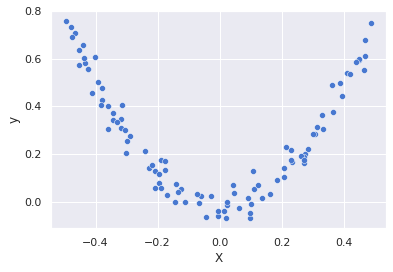

In [4]:
sns.scatterplot(x="X", y="y", data=data)
plt.show()

## Step 1 - Построение модели на данных

Чтобы создать регрессионную модель бустинга мы начем со слабой модели которая предсказывает наш действительный таргет $y$. Как уточнялось ранее будем использовать дерево решений с небольшой глубиной `max_depth`:

In [5]:
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Визуализация натренированного дерева

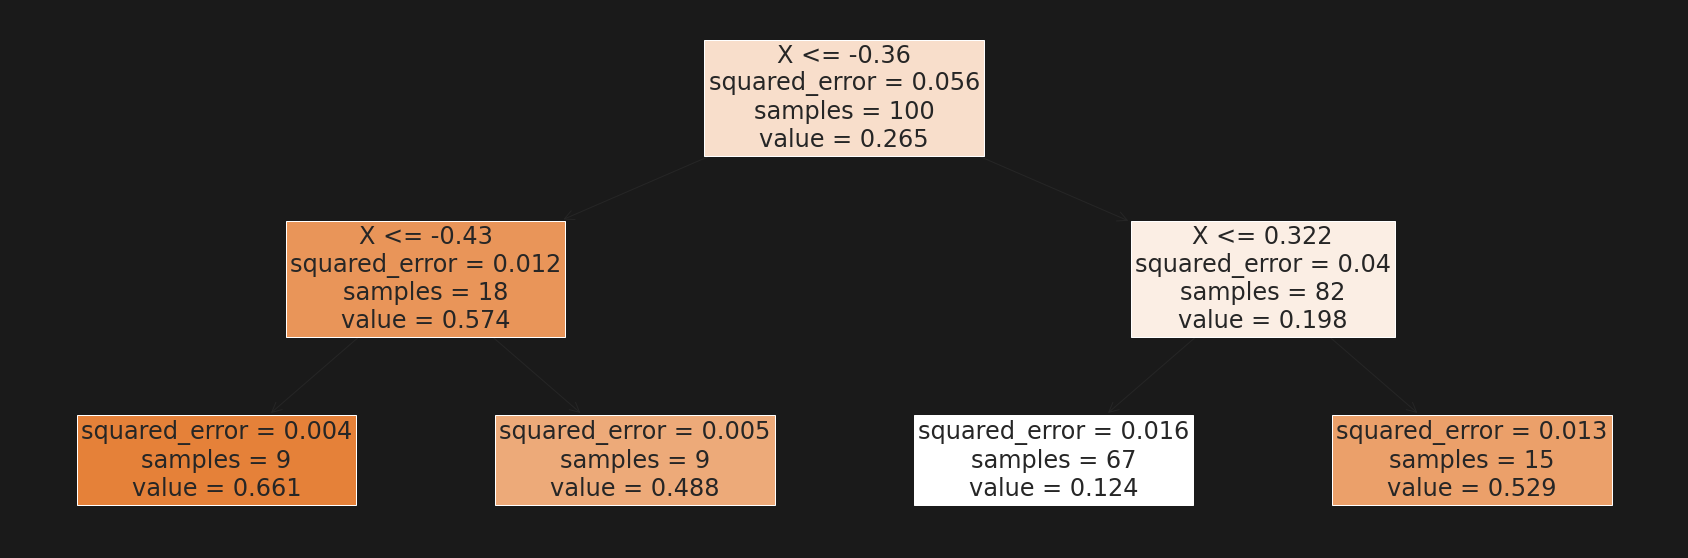

In [6]:
plot_regression_tree(tree_1, data.columns, fontsize=24)

Добавим колону предсказаний в наш датафрейм

In [7]:
data["Tree 1 prediction"] = tree_1.predict(X)
data.head()

,X,y,Tree 1 prediction
0,-0.125460,0.051573,0.123566
1,0.450714,0.594480,0.528568
2,0.231994,0.166052,0.123566
3,0.098658,-0.070178,0.123566
4,-0.343981,0.343986,0.123566


И визуализируем качество предсказаний нашего дерева:

In [20]:
def plot_predictions(ax, regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    ax.plot(X[:, 0], y, data_style, label=data_label)
    ax.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    ax.axis(axes)
    ax.set_ylabel("$y$", fontsize=16)
    ax.set_xlabel("$X$", fontsize=16)

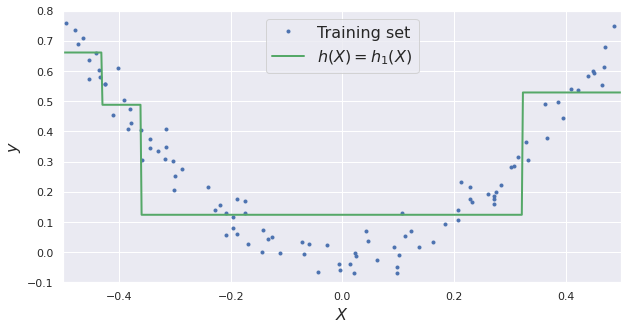

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
plot_predictions(
    ax, [tree_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X)=h_1(X)$", style="g-", data_label="Training set"
)

## Step 2 - Построение модели на остатках

Неудивительно что слабая модель не смогла найти зависимость в данных (слишком большое смещение). Однако мы можем увеличить качество модели натренировав второе дерево решений на _остаточных ошибках_ от первого дерева:

In [22]:
data["Tree 1 residual"] = data["y"] - data["Tree 1 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404


In [23]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_2.fit(X, data["Tree 1 residual"])

DecisionTreeRegressor(max_depth=2)

## Step 3 - Создание композиции моделей

Теперь у нас есть ансамбль из двух деревьев. Мы можем получить предсказание ансамбля путем суммирования предсказаний с двух деревьев:

In [24]:
data["Tree 2 prediction"] = tree_2.predict(X)
data["Tree 1 + tree 2 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2))
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404


Построим график предсказания второго дерева для ошибок от первого дерева и также общий график для предсказания всего ансамбля

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


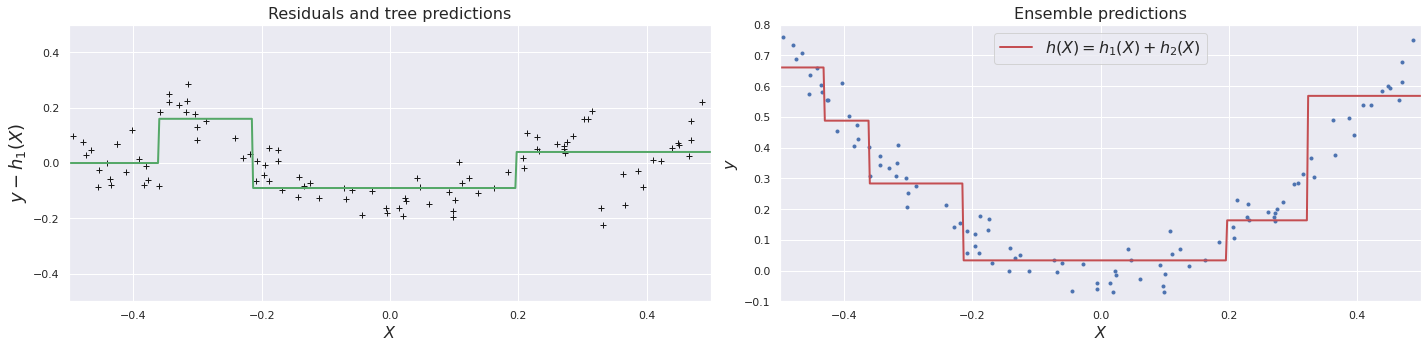

In [28]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plot_predictions(
    ax0,
    [tree_2],
    X,
    data["Tree 1 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_2(X)$",
    style="g-",
    data_style="k+",
    data_label="Residuals",
)
ax0.set_ylabel("$y - h_1(X)$", fontsize=18)
ax0.set_title("Residuals and tree predictions", fontsize=16)

plot_predictions(ax1, [tree_1, tree_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X)$")
ax1.set_title("Ensemble predictions", fontsize=16)
fig.tight_layout()

From the figure, we see that the ensemble's predictions have improved compared to our first crappy model!

## Step 4 - остатки и повторение

Не сложно увидеть как повторить процедуру добавления новых моделей:

$$ F_{m+1}(x) = F_m(x) + h_m(x)\,, \qquad \mathrm{for} \, m \geq 0 $$

In [29]:
data["Tree 1 + tree 2 residual"] = data["Tree 1 residual"] - data["Tree 2 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168,0.018405
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481,0.025998
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479,0.002573
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168,-0.103346
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404,0.060582


In [30]:
tree_3 = DecisionTreeRegressor(max_depth=2)
tree_3.fit(X, data["Tree 1 + tree 2 residual"])

DecisionTreeRegressor(max_depth=2)

In [31]:
data["Tree 3 prediction"] = tree_3.predict(X)
data["Tree 1 + tree 2 + tree 3 prediction"] = sum(tree.predict(X) for tree in (tree_1, tree_2, tree_3))
data["Final residual"] = data["Tree 1 + tree 2 residual"] - data["Tree 3 prediction"]
data.head()

,X,y,Tree 1 prediction,Tree 1 residual,Tree 2 prediction,Tree 1 + tree 2 prediction,Tree 1 + tree 2 residual,Tree 3 prediction,Tree 1 + tree 2 + tree 3 prediction,Final residual
0,-0.125460,0.051573,0.123566,-0.071993,-0.090398,0.033168,0.018405,0.007043,0.040212,0.011361
1,0.450714,0.594480,0.528568,0.065911,0.039913,0.568481,0.025998,-0.068529,0.499952,0.094528
2,0.231994,0.166052,0.123566,0.042485,0.039913,0.163479,0.002573,0.007043,0.170523,-0.004471
3,0.098658,-0.070178,0.123566,-0.193744,-0.090398,0.033168,-0.103346,0.007043,0.040212,-0.110390
4,-0.343981,0.343986,0.123566,0.220420,0.159838,0.283404,0.060582,0.007043,0.290448,0.053538


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


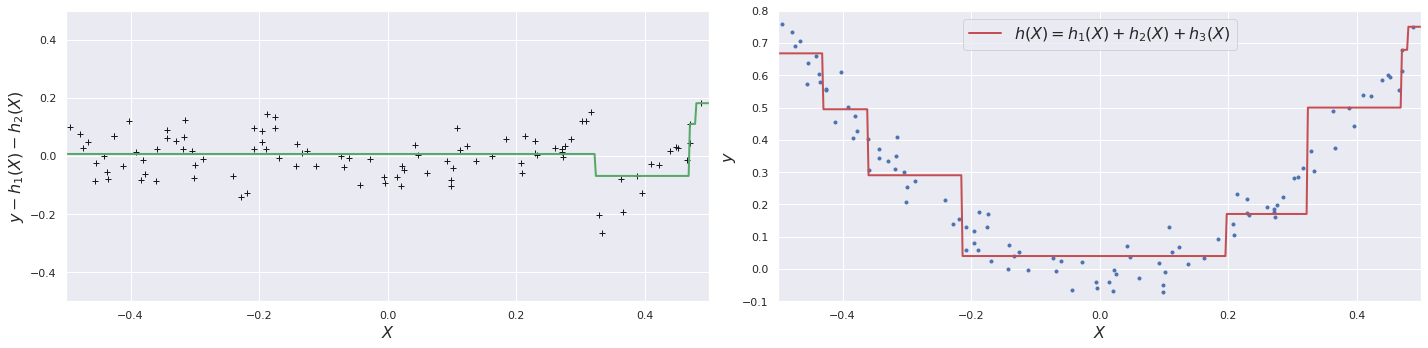

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plot_predictions(
    ax0,
    [tree_3],
    X,
    data["Tree 1 + tree 2 residual"],
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_3(X)$",
    style="g-",
    data_style="k+",
)
ax0.set_ylabel("$y - h_1(X) - h_2(X)$", fontsize=16)

plot_predictions(
    ax1, [tree_1, tree_2, tree_3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(X) = h_1(X) + h_2(X) + h_3(X)$",
)
fig.tight_layout()

Как и было обещано, добавление большего количества моделей в ансамбль улучшает прогнозы (по крайней мере, качественно).!

## Gradient boosting c scikit-learn

Создание градиента бустинга вручную не самое приятное занятие, поэтому на практике лучше использовать класс lightgbm [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). Как и у случайного леса он имеет параметры `max_depth` и `min_child_samples` (`min_samples_leaf`) которые контролируют размер деревьев, также параметр `n_estimators` для размера ансамбля. Например алгорим который мы создали вручную:

In [39]:
gbrt = lightgbm.LGBMRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

LGBMRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

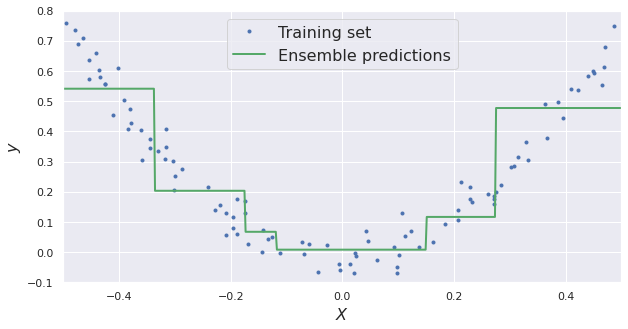

In [41]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
plot_predictions(
    ax, [gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions", style="g-", data_label="Training set"
)

## Выбор гиперпараметров

There are two main hyperparameters that you need to tune to prevent a boosted regression ensemble from overfitting the training set:

В отличие от случайных деревьев, в бустинге увеличение числа деревьев `n_estimators` не всегда приводит к улучшению качества решения на тесте. Зависимость, как правило унимодальная. Число деревьев, при котором качество максимально, зависит от темпа обучения `learning_rate`: чем меньше темп, тем больше деревьев нужно, но зависимость нелинейная.

При оптимизации параметров обычно фиксируют число деревьев (оно должно быть не очень большим, чтобы алгоритм быстро обучался), подбирая под него темп и значения остальных параметров. При построении итогового алгоритма увеличивают число деревьев и находят соответствующее значение темпа (оставляя остальные параметры неизменными)

### Эффект скорости обучения

Чтобы показать эффект скорости обучения натренируем 2 алгорима на разных экстемумах:

In [56]:
gbrt_high_lr = lightgbm.LGBMRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42, min_child_weight=0)
gbrt_high_lr.fit(X, y)

gbrt_low_lr = lightgbm.LGBMRegressor(max_depth=2, n_estimators=2000, learning_rate=0.1, random_state=42, min_child_weight=0)
gbrt_low_lr.fit(X, y)

LGBMRegressor(max_depth=2, min_child_weight=0, n_estimators=2000,
              random_state=42)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


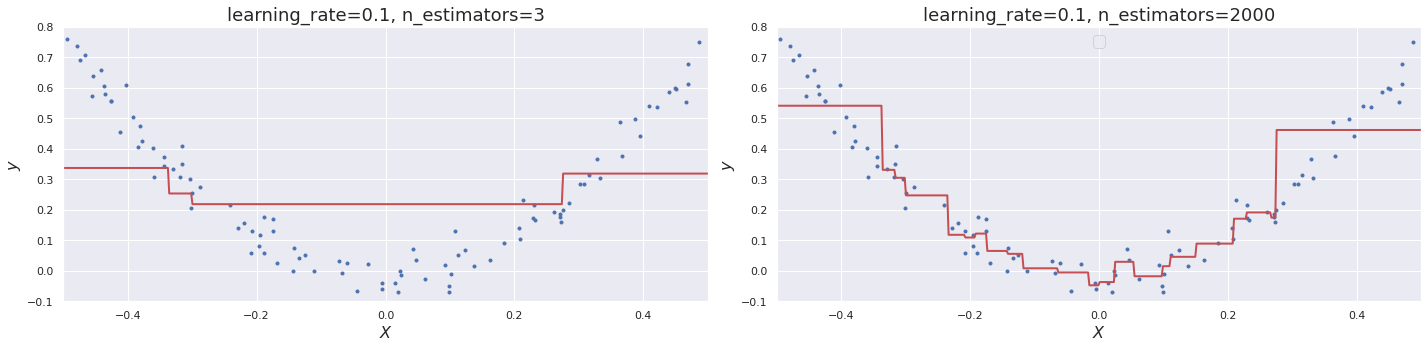

In [57]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 5))

plot_predictions(ax0, [gbrt_high_lr], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
ax0.set_title(f"learning_rate={gbrt_high_lr.learning_rate}, n_estimators={gbrt_high_lr.n_estimators}", fontsize=18)

plot_predictions(ax1, [gbrt_low_lr], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
ax1.set_title(f"learning_rate={gbrt_low_lr.learning_rate}, n_estimators={gbrt_low_lr.n_estimators}", fontsize=18)

fig.tight_layout()

### Early stopping

На практике параметры находятся на кроссвалидации. Однако установлено что небольшая скорость обучения 0.1 показывает хорошую генерализацию. Для нахождения оптимального количества деревьев мы можем воспользоваться техникой early_stopping, которая измеряет качество алгоритма на валидационных данных на каждом шаге обучения бустинга

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=49)

train_dataset = lightgbm.Dataset(X_train, y_train)
valid_dataset = lightgbm.Dataset(X_valid, y_valid)


booster = lightgbm.train(
    {"objective": "regression", "verbosity": -1, "metric": "rmse", "max_depth": 2, "n_estimators": 120, "learning_rate": 0.1},
    train_set=train_dataset, valid_sets=(valid_dataset,),
    early_stopping_rounds=120,
)

[1]	valid_0's rmse: 0.201882
Training until validation scores don't improve for 120 rounds
[2]	valid_0's rmse: 0.189033
[3]	valid_0's rmse: 0.178223
[4]	valid_0's rmse: 0.169221
[5]	valid_0's rmse: 0.161808
[6]	valid_0's rmse: 0.155775
[7]	valid_0's rmse: 0.150925
[8]	valid_0's rmse: 0.147076
[9]	valid_0's rmse: 0.143975
[10]	valid_0's rmse: 0.141072
[11]	valid_0's rmse: 0.139211
[12]	valid_0's rmse: 0.137307
[13]	valid_0's rmse: 0.135847
[14]	valid_0's rmse: 0.135167
[15]	valid_0's rmse: 0.133704
[16]	valid_0's rmse: 0.133423
[17]	valid_0's rmse: 0.132464
[18]	valid_0's rmse: 0.131727
[19]	valid_0's rmse: 0.131771
[20]	valid_0's rmse: 0.131304
[21]	valid_0's rmse: 0.131243
[22]	valid_0's rmse: 0.13143
[23]	valid_0's rmse: 0.131225
[24]	valid_0's rmse: 0.131084
[25]	valid_0's rmse: 0.131315
[26]	valid_0's rmse: 0.131248
[27]	valid_0's rmse: 0.13138
[28]	valid_0's rmse: 0.131448
[29]	valid_0's rmse: 0.13158
[30]	valid_0's rmse: 0.131715
[31]	valid_0's rmse: 0.13185
[32]	valid_0's rmse: 

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Optimal number of trees: 24
Minimum validation MSE: 0.017183040913288202


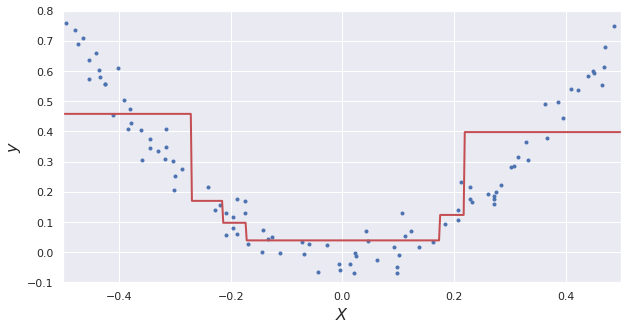

In [99]:
print(f"Optimal number of trees: {booster.best_iteration}")
print(f"Minimum validation MSE: {booster.best_score['valid_0']['rmse'] ** 2}")

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))

plot_predictions(ax, [booster], X, y, axes=[-0.5, 0.5, -0.1, 0.8])